<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/Car_sales_predictions_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today you are a Data Scientist at Tesla! 
## You have assigned a new project to look at car sales from Quarters 1-2 in California for 2019 to make predictions as to which cars will be sold more than the others in Q3 and Q4, to ensure enough inventory to meet demands!

### If running this notebook in Google Colab, run the following cells first. Make sure you've placed the Q12 and Q34 sales data in the same Google Drive folder as this notebook.

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Replace the ID with ID of file you want to access. To get this ID: 

1.   Right-click on the name of the appropriate file in your Google Drive
2.   Click "Get link"
3.   Copy the characters between `d/` and the following slash
4.   Paste them into the dictionary argument of the call to `drive.CreateFile()` as the value associated with the 'id' key. Make sure that this value is a string.



In [3]:
# Replace the ID with ID of file you want to access
Q12 = drive.CreateFile({'id':'1rq391xjFLCtRlBhD7Q29yC_crETqFEcS'}) 
Q12.GetContentFile('sales_Q12_2019.csv') 
Q34 = drive.CreateFile({'id':'1X0nZPwG7AW2M4TYXFFr26eg_GhZvaVWF'}) 
Q34.GetContentFile('sales_Q34_2019.csv') 

### Import the necessary modules

In [4]:
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in the CSV file containing the California sales data for Quarters 1 and 2

Then examine the data's shape and first few rows

In [5]:
df_sales = pd.read_csv("sales_Q12_2019.csv")
print(df_sales.shape)
df_sales.head()

(5837, 76)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP,dealer_state,date
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610,California,2019-04-28
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505,California,2019-03-14
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890,California,2019-06-12
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055,California,2019-03-04
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830,California,2019-01-23


In [6]:
df_sales.columns

Index(['main_S60_1', 'main_S60_2', 'main_type_SP100D', 'main_type_S60D_1',
       'main_type_S60D_2', 'main_type_S70', 'main_type_S70D', 'main_type_S75',
       'main_type_S75D', 'main_type_S80', 'main_type_S80D', 'main_type_S85',
       'main_type_S85P', 'main_type_P85D', 'main_type_S90', 'main_type_S90D',
       'main_type_S100D', 'engine_A', 'engine_B', 'engine_C', 'engine_D',
       'engine_E', 'engine_F', 'engine_G', 'engine_H', 'engine_I', 'engine_J',
       'engine_K', 'engine_L', 'engine_M', 'engine_N', 'engine_O', 'engine_P',
       'engine_Q', 'engine_R', 'engine_S', 'engine_T', 'engine_U', 'engine_V',
       'engine_W', 'engine_X', 'engine_Y', 'engine_Z', 'sales_1', 'sales_2',
       'sales_3', 'sales_4', 'sales_5', 'sales_6', 'sales_7', 'sales_8',
       'sales_9', 'sales_10', 'sales_11', 'sales_12', 'sales_13', 'sales_14',
       'sales_15', 'sales_16', 'sales_17', 'sales_18', 'sales_19', 'sales_20',
       'sales_21', 'sales_22', 'sales_23', 'sales_24', 'sales_25', 'sales

All columns are one hot encoded. Actual columns are 
- main_S60 (1,2)
- main_type (SP100D, S60D_1, S60D_2, S70, S70D, S75, S85P, P85D, S90, S90D, S100D)
- engine (A to Z) 
- sales (1 to 30)
- MSRP 
- dealer_state
- date

In [7]:
df_sales['dealer_state'].value_counts()

California    5837
Name: dealer_state, dtype: int64

In [8]:
df_sales['date'].value_counts()

2019-04-30    237
2019-05-31    210
2019-02-28    189
2019-04-01    173
2019-01-31    115
             ... 
2019-04-04      4
2019-01-05      3
2019-04-02      2
2019-03-01      2
2019-05-01      2
Name: date, Length: 179, dtype: int64

### Begin cleaning the data

Eliminate the `'dealer_state'` and `'date'` columns. The former is useless to our model, since we already know that our dataset is restricted to California sales. While we could possibly extract useful information from the `'date'` column (for example, to determine whether more cars are sold on weekends than weekdays), we'll be focusing on car configurations in this exercise.

In [9]:
df_sales = df_sales.drop(columns=['dealer_state','date'])
df_sales.head()

,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44610
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41505
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58890
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51055
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70830


### Read in the CSV file containing the California sales data for Quarters 3 and 4

The `'dealer_state'` and `'date'` columns have already been eliminated in this dataset, so you don't need to worry about them here. Examine the data's shape and first few rows.

In [10]:
### START CODE HERE ###
# Read in the Q34 data
df_pred = pd.read_csv("sales_Q34_2019.csv")
# Print the shape of the data
print(np.shape(df_pred))
# Examine the first few rows of the data
df_pred.head()
### END CODE HERE ###

(6666, 74)


,main_S60_1,main_S60_2,main_type_SP100D,main_type_S60D_1,main_type_S60D_2,main_type_S70,main_type_S70D,main_type_S75,main_type_S75D,main_type_S80,main_type_S80D,main_type_S85,main_type_S85P,main_type_P85D,main_type_S90,main_type_S90D,main_type_S100D,engine_A,engine_B,engine_C,engine_D,engine_E,engine_F,engine_G,engine_H,engine_I,engine_J,engine_K,engine_L,engine_M,engine_N,engine_O,engine_P,engine_Q,engine_R,engine_S,engine_T,engine_U,engine_V,engine_W,engine_X,engine_Y,engine_Z,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,MSRP
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,51355
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71580
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66790
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72330
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55370


# Task I. Consolidate data by finding numbers of unique car combinations sold for training and test data sets

You've probably noticed that 73 of the 74 columns in our Q12 and Q34 datasets are one-hot-encoded representations of the car's `'main_type'`, `'engine'`, and `'sales_version'` values. You've probably also noticed that the final column is the car's `'MSRP'`, or manufacturer's (Tesla's, in this case) suggested retail price. In its current form, the sales data doesn't contain a target. The car's `'main_type'`, `'engine'`, `'sales_version'`, and `'MSRP'` values are all known to us before the time of the sale and do not, by themselves, offer us anything which we can predict. 

However, each row represents the sale of a single car. If we define a unique car type by its combination of `'main_type'`, `'engine'`, and `'sales_version'` values, the number of rows displaying that combination corresponds to the number of times during that half of the year that that distinct type of car was sold in California. Therefore, we can make training and test datasets where each row now corresponds to a unique car type, and the target value is how many times that car type was sold in California during a given half of the year.

## This task requires data wrangling!
## Create functions that read the Q12 (df_sales) and Q34 (df_pred) data sets and create train_X, train_Y, test_X and test_Y, respectively. Use pandas and NumPy as needed.

train_X, test_X = unique row combinations without MSRP column

train_Y, test_Y = number of unique cars sold

In [11]:
def get_features_and_targets(df):
  # first drop MSRP column
  data = df.drop(columns=['MSRP'])

  # get count of sales with unique car type
  sales_uniq_cnts = data.value_counts(sort=False, normalize=True)
  # create dictionary with unique car type and sales count
  sales_dict = dict(zip(sales_uniq_cnts.keys().tolist(), sales_uniq_cnts.tolist())) 

  # drop duplicates 
  sales_w_msrp = df.drop_duplicates(subset=df.columns.values.tolist())

  # create dictionary with unique car type and MSRP
  sales_wo_msrp = sales_w_msrp.drop(columns=['MSRP'])
  # use min-max normalization to scale msrp value to be in between 0 & 1
  sales_msrp = ((sales_w_msrp['MSRP'] - min(sales_w_msrp['MSRP']))/(max(sales_w_msrp['MSRP']) - min(sales_w_msrp['MSRP']))).tolist()
  sales_wo_msrp_keys = sales_wo_msrp.value_counts(sort=False).keys().tolist()
  sales_msrp_dict = dict(zip(sales_wo_msrp_keys, sales_msrp)) 

  # finally using above 2 dictionaries create final data
  final_data = [(*key, sales_msrp_dict[key], sales_dict[key]) for key in sales_wo_msrp_keys]
  final_data = pd.DataFrame(final_data, columns=[*sales_wo_msrp.columns.tolist(), 'MSRP', 'number_of_sales'])

  # target/dependent varaible
  y = np.array(final_data['number_of_sales'])
  # features/independent variables
  X = np.array(final_data.drop(columns=['number_of_sales']))
  return X, y

### Extract features and targets as defined above from both the Q12 and Q34 datasets

In [12]:
### START CODE HERE ###
# Extract training features and targets from the Q12 data
train_X, train_Y = get_features_and_targets(df_sales)
# Extract test features and targets from the Q34 data
test_X, test_Y = get_features_and_targets(df_pred)
### END CODE HERE ###
print(f"Number of unique cars in Q12 = {len(train_Y)}")
print(f"Number of unique cars in Q34 = {len(test_Y)}")

Number of unique cars in Q12 = 66
Number of unique cars in Q34 = 71


You probably noticed that the Q12 and Q34 datasets contained differing numbers of distinct cars. Clearly, some new models were introduced by Q3, but were any discontinued by the end of Q2? Let's find out.

In [13]:
# How many unique cars in 2012 (Q1:Q4)?
### START CODE HERE ### 
# Concatenate the Q12 and Q34 DataFrames into a single DataFrame
df_full = pd.concat([df_sales, df_pred])
# Extract features and targets from the concatenated Q14 data
data_X, data_Y = get_features_and_targets(df_full)
### END CODE HERE ###
print(f"Number of unique cars in Q12 and Q34 = {len(data_Y)}")

Number of unique cars in Q12 and Q34 = 80


For this section we will utilize set theory. For a refresher to set theory, please follow the video at https://www.youtube.com/watch?v=B1v9OeCTlu0.

The following set theory equations are true for any two events $A$ and $B$:

$$(A \cup B) = (A) + (B) -  (A \cap B)$$
$$(A \cap B) = (A) + (B) -  (A \cup B)$$
$$(A) =  (A \cap B) +  (A \cap B^c)$$

Use them to determine how many car models were sold in both halves of 2019, how many were discontinued by the second half of the year, and how many were launched in the second half of the year.

In [14]:
### START CODE HERE ###
#models_q12_or34 refers to (A Union B), models_q14 refers to (A intersection B)
models_q12_or_q34 = len(data_Y)
models_q12 = len(train_Y)
models_q34 = len(test_Y)
models_q14 = models_q12 + models_q34 - models_q12_or_q34
discontinued = models_q12 - models_q14
launched = models_q34 - models_q14
print(f"{models_q14} models were sold throughout 2019")
print(f"{discontinued} models were discontinued by the second half of 2019")
print(f"{launched} models were launched in the second half of 2019")
### END CODE HERE ###

57 models were sold throughout 2019
9 models were discontinued by the second half of 2019
14 models were launched in the second half of 2019


# Task II: Visualize the training and test targets any way you see fit

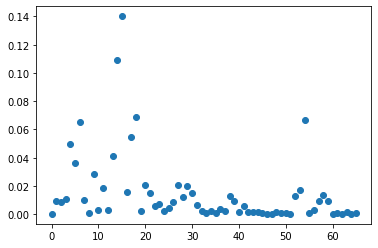

In [15]:
# Visualize the training targets
### START CODE HERE ###
plt.scatter(range(len(train_Y)), train_Y)
plt.show()
### END CODE HERE ###

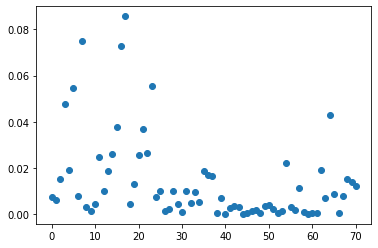

In [16]:
# Visualize the test targets
### START CODE HERE ###
plt.scatter(range(len(test_Y)), test_Y)
plt.show()
### END CODE HERE ###

# Task III: Apply Gradient Descent (Linear, Polynomial)

Initialize the $\theta$ parameters as a column vector of zeros, one for every feature in the training data plus one for bias. 

Also set hyperparameters for learning rate and maximum number of iterations through the training data.

In [17]:
# Initialize learned parameters theta and hyperparameters
s_theta = np.zeros((train_X.shape[1]+1, 1))
s_learning_rate = 0.001
s_max_iteration = 1000

### Hypothesis Function

Define your hypothesis function $h$ (which you use to make predictions $\hat{Y}$ as the matrix product of your features data X and parameters theta, in that order. 

Don't forget to add a 0th column of ones to X to account for the bias/offset parameter.

In [18]:
# Define your hypothesis function according to the instructions above
def h (theta, X) :
    ### START CODE HERE ###
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    return np.matmul(tempX, theta)
    ### END CODE HERE ###

Define your loss function as **half** the MSE (mean squared error) between your actual and predicted Y values. 

Recall that the predicted Y values are a function of theta and X.


In [19]:
# Loss Function
def loss (theta, X, Y) :
    ### START CODE HERE ###
    return np.average(np.square(Y - h(theta, X))) / 2
    ### END CODE HERE ###

### Gradient of Hypothesis Function

One can verify through straightforward (if somewhat tedious) multivariable calculus that the gradient of the loss function $J$ with respect to the parameters $\theta$ is 

$$ \frac{\partial J}{\partial \theta} = - \frac{1}{m} X^T \cdot (Y - \hat{Y})$$.

Here, $X$ has been augmented with a bias column. 

Set up a function to compute this gradient.

In [20]:
def gradient (theta, X, Y) :
    ### START CODE HERE ###
    # Create a temporary X array with an added 0th bias column
    tempX = np.ones((X.shape[0], X.shape[1] + 1))
    tempX[:,1:] = X
    # Compute the gradient according to the instructions above
    d_theta = - np.dot(tempX.T, Y - h(theta, X)) / X.shape[0]
    ### END CODE HERE ###
    return d_theta

### Gradient Descent

Set up a function to train your linear regression model with gradient descent, i.e. calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. Recall that the general gradient descent update formula is $\theta := \theta - \alpha \frac{\partial J}{\partial \theta}$. We've provided the skeleton of a stochastic gradient descent function, but you're welcome to experiment with batch and/or minibatch gradient descent. Also recall that the aforementioned gradient descent methods differ in how frequently they calculate $\frac{\partial J}{\partial \theta}$ and update $\theta$. 

In [21]:
def stochastic_gradient_descent (theta, X, Y, learning_rate, max_iteration, gap) :
    ### START CODE HERE ###
    # Initialize the cost as an array of zeros, one for each iteration through the dataset
    cost = np.zeros(max_iteration)
    # Loop over the dataset
    for i in range(max_iteration):
        # Loop over each row in the dataset
        for j in range(X.shape[0]):
            # Compute the gradient from the current row in X and the associated Y value
            # Make sure that both X and Y are represented as 2D row vectors
            d_theta = gradient(theta, X[j:j+1], Y[j:j+1])
            # Update theta
            theta = theta - learning_rate * d_theta
        # Update the cost array for the current iteration
        cost[i] = loss(theta, X, Y)
    ### END CODE HERE ###
        if i % gap == 0 :
            print ('iteration : ', i, ' loss : ', loss(theta, X, Y)) 
    return theta, cost

In [22]:
s_theta, s_cost = stochastic_gradient_descent(s_theta, train_X, train_Y, s_learning_rate, s_max_iteration, 100)

iteration :  0  loss :  0.00041839119393456784
iteration :  100  loss :  0.00037038472727608833
iteration :  200  loss :  0.00041178993382498964
iteration :  300  loss :  0.00043969108122972637
iteration :  400  loss :  0.00045862038870268855
iteration :  500  loss :  0.0004719278828012426
iteration :  600  loss :  0.000481564820075098
iteration :  700  loss :  0.0004886995702462828
iteration :  800  loss :  0.0004940725922886578
iteration :  900  loss :  0.0004981769823604529


### Generate Predictions from Test Data

In [23]:
### START CODE HERE ###
GD_P = h(s_theta,test_X)
### END CODE HERE ###
# Set any negative predictions to 0
GD_P[GD_P<0] = 0

### Visualize the predicted and actual test labels

Using SGD: MSE = 0.00014846072152146746, R2 = 0.9096514635787359


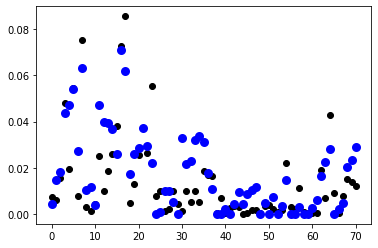

In [24]:
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(GD_P)), GD_P, color='blue', linewidth=3)
from sklearn.metrics import mean_squared_error as MSE

# This function evaluates the R**2 statistic
def r2(Yt,Yp):
    yhat = Yp                         
    ybar = np.sum(Yt)/len(Yt)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((Yt - ybar)**2)    
    results = ssreg / sstot
    return results


print("Using SGD: MSE = {}, R2 = {}".format(MSE(test_Y,GD_P), r2(test_Y,GD_P)))

# Task IV: Normal Equations

Since our training dataset isn't very large, let's generate predictions using the normal equations: 

$$W = (X^T \cdot X)^{-1} \cdot X^T \cdot Y$$ 
$$\hat{Y} = W^T \cdot X$$

and see how they compare to the predictions which we obtained from gradient descent.

In [25]:
from numpy.linalg import pinv

### START CODE HERE ###
# Compute the inverse of the matrix product of the transpose of X and X
# Adding bias for trainX
temp_trainX = np.ones((train_X.shape[0], train_X.shape[1] + 1))
temp_trainX[:,1:] = train_X

inv1 = pinv(np.dot(temp_trainX.T, temp_trainX))
# Compute W using the first of the Normal Equations
W1 = np.dot(np.dot(inv1, temp_trainX.T), train_Y)
# Compute the predicted Y values using the second of the Normal Equations

# Adding bias for test_X
temp_testX = np.ones((test_X.shape[0], test_X.shape[1] + 1))
temp_testX[:,1:] = test_X

PN1 = np.array(np.dot(W1, temp_testX.T).T)
### END CODE HERE ###

# Set any negative predictions to 0
PN1[np.where(PN1<0)]=0

RMSE, R2 for prediction all features = 0.00017997774939246966 1.039993187906375


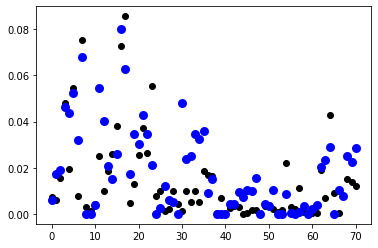

In [26]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN1)), PN1, color='blue', linewidth=3)
print("RMSE, R2 for prediction all features =", MSE(test_Y,PN1), r2(test_Y,PN1)) #[Low error high corr]

### Regularized Normal Equations

In [27]:
print('Recall that our training features array train_X has')
print(f'm = {train_X.shape[0]} rows and n = {train_X.shape[1]} columns')

Recall that our training features array train_X has
m = 66 rows and n = 74 columns


`train_X` is thus wider than it is tall, which suggests that the regularized normal equations might perform better in generating label predictions. In this case, we modify the first of the normal equations given above to 

$$W = (X^T \cdot X + \lambda m I)^{-1} \cdot X^T \cdot Y$$.

Here, $\lambda$ is the regularization parameter and $m$ is the number of rows in $X$.

### Repeat the previous parts of Task IV, but this time incorporate regularization

RMSE, R2 for using normal equation with Regularizatino = 0.00016043146950631002 0.8603090907710285


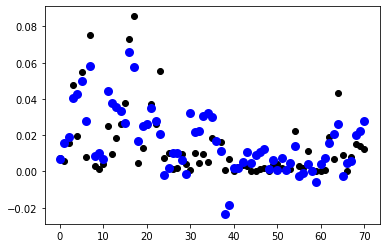

In [28]:
from numpy.linalg import inv
### START CODE HERE ###

m = train_X.shape[0]

# add bias
temp_trainX = np.ones((train_X.shape[0], train_X.shape[1] + 1))
temp_trainX[:,1:] = train_X

# matrix with zeroth index as 0
idm = np.identity(train_X.shape[1]+1)
# as per Andrews Lecture, this should not be identity matrix.
# 0th index should be 0
idm[0,0] = 0  

# lambda > 0
lam = 0.01

inv1 = inv(np.dot(temp_trainX.T, temp_trainX) + lam * m * idm)

W1 = np.dot(np.dot(inv1, temp_trainX.T), train_Y)
# Compute the predicted Y values using the second of the Normal Equations

# Adding bias for test_X
temp_testX = np.ones((test_X.shape[0], test_X.shape[1] + 1))
temp_testX[:,1:] = test_X

PN2 = np.array(np.dot(W1, temp_testX.T).T)

# Set any negative predictions to 0
PN2[np.where(PN1<0)]=0

# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(PN2)), PN2, color='blue', linewidth=3)
print("RMSE, R2 for using normal equation with Regularizatino =", MSE(test_Y,PN2), r2(test_Y,PN2)) #[Low error high corr]

### END CODE HERE ###

# Task V: Non-linear Regression Models (GLM, DT) 

### Generalized Linear Models

`sm` (our alias for `statsmodels.api`) contains a `GLM` class. Use it to instantiate a model. The relevant parameters are training labels, training features, and `ffamily`, i.e. the family of distributions to which we assume our prediction errors belong. Some potentially good choices for `ffamily` include Gaussian, Gamma, and Logit.

In [62]:
# GLM 
import statsmodels.api as sm
### START CODE HERE ###
# Instantiate the GLM
glm_gamma = sm.GLM(train_Y, train_X, family=sm.families.Gaussian())
# Train the GLM
glm_results = glm_gamma.fit()
### END CODE HERE ###
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   66
Model:                            GLM   Df Residuals:                       34
Model Family:                Gaussian   Df Model:                           31
Link Function:               identity   Scale:                      0.00050858
Method:                          IRLS   Log-Likelihood:                 178.51
Date:                Mon, 31 May 2021   Deviance:                     0.017292
Time:                        13:51:53   Pearson chi2:                   0.0173
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -7.3e-18   5.94e-18     -1.228      0.2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


### Generate predictions from the test data

In [63]:
### START CODE HERE ###
G_P = glm_gamma.predict(glm_results.params, test_X)
### END CODE HERE ###
# Set any negative predictions to 0
G_P[G_P<0]=0

RMSE, R2 for GLM= 0.000181426449801964 1.0426719372109274


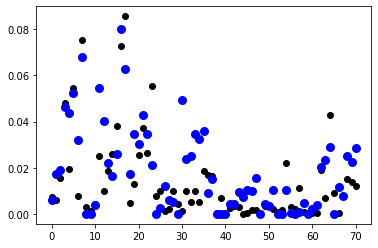

In [64]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(G_P)), G_P, color='blue', linewidth=3)
print("RMSE, R2 for GLM=", MSE(test_Y,G_P), r2(test_Y,G_P)) 

### Random Forest Regression

Use the `RandomForestRegressor` from `sklearn.ensemble` to generate predictions. The relevant parameters are the `max_depth` of the trees and the `random_state`, to ensure reproducibility.

In [32]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestRegressor
# Instantiate the random forest regression model
regr = RandomForestRegressor(max_depth=10, random_state=0)
# Train the model
regr.fit(train_X, train_Y)
# Generate predictions from the test data
pred_rf = regr.predict(test_X)
### END CODE HERE ###

In [33]:
# Set any negative predictions to 0
pred_rf[np.where(pred_rf<0)]=0

RMSE, R2 for Decision Trees= 0.00015440700358590402 0.5928663804205114


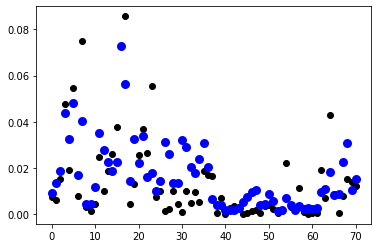

In [34]:
# Plot outputs
plt.scatter(range(len(test_Y)), test_Y,  color='black')
plt.scatter(range(len(pred_rf)), pred_rf, color='blue', linewidth=3)
print("RMSE, R2 for Decision Trees=", MSE(test_Y,pred_rf), r2(test_Y,pred_rf)) #[Low error high corr]

## Populate the table below with the results of your experiments above. Which models performed best?

## Results
---

| Method | MSE | R2 |
|--|--|--|
| Gradient Descent | 0.00014 | 0.90965 |
| Normal Equations | 0.00017 | 1.03999 |
| Regularized Normal Equations | 0.00016 | 0.86030 | 
| GLM | 0.00018 | 1.04267 |
| Descision Trees | 0.00015 | 0.59286 | 

## Finally, pick some car types for which your models over- and under-predicted sales. Attempt to determine the root causes. Write your findings below.

In [51]:
def get_predicted_car_types(prediction):
  final_pred = pd.DataFrame(test_X, columns=df_pred.columns).merge(pd.DataFrame(prediction, columns=['predicted_sales']), 
                                                      left_index=True, right_index=True)
  final_pred = final_pred.sort_values(by='predicted_sales', ascending=False)
  print("== Top 5 car types which might have high predictions == ")
  for i in final_pred.head().index:
    high_predict = final_pred.loc[[i]]
    car_type = "+".join(high_predict[high_predict.eq(1.0)].dropna(axis=1).columns.tolist())
    print(car_type, high_predict['predicted_sales'].tolist()[0])
  print("\n == Bottom 5 car types which might have high predictions == ")
  
  for i in final_pred.tail().index:
    low_predict = final_pred.loc[[i]]
    car_type = "+".join(low_predict[low_predict.eq(1.0)].dropna(axis=1).columns.tolist())
    print(car_type, low_predict['predicted_sales'].tolist()[0])


In [52]:
# Gradient Descent
get_predicted_car_types(GD_P)

== Top 5 car types which might have high predictions == 
main_type_P85D+engine_Q+sales_11 0.07116383084579286
main_type_P85D+sales_10 0.06302135383465159
main_type_P85D+engine_Q+sales_10 0.06199087020064412
main_type_S100D+engine_A+sales_8 0.0539193288518485
main_type_P85D+engine_Z+sales_11 0.04738178235944425

 == Bottom 5 car types which might have high predictions == 
main_type_S85P+engine_Z+sales_1 0.0
main_type_S70+engine_Z+sales_24 0.0
main_type_S85P+engine_Z+sales_28 0.0
main_type_S80+engine_Q+sales_24 0.0
main_type_S80D+engine_Q+sales_17 0.0


In [53]:
# Normal Equation
get_predicted_car_types(PN1)

== Top 5 car types which might have high predictions == 
main_type_P85D+engine_Q+sales_11 0.08021711289344446
main_type_P85D+sales_10 0.06793004739862546
main_type_P85D+engine_Q+sales_10 0.06282262730186808
main_type_P85D+engine_Z+sales_11 0.05444539554085283
main_type_S100D+engine_A+sales_8 0.05220822418314537

 == Bottom 5 car types which might have high predictions == 
main_type_S70D+sales_9 0.0
main_type_P85D+engine_Z+sales_30 0.0
main_type_S80+engine_Q+sales_24 0.0
main_type_S80D+engine_Q+sales_17 0.0
main_type_S80+engine_Q+sales_9 0.0


In [66]:
# Normal Equation with regularization
get_predicted_car_types(PN2)

== Top 5 car types which might have high predictions == 
main_type_P85D+engine_Q+sales_11 0.06618339781054704
main_type_P85D+sales_10 0.058360605320530355
main_type_P85D+engine_Q+sales_10 0.05786388230967863
main_type_S100D+engine_A+sales_8 0.04968433281931865
main_type_P85D+engine_Z+sales_11 0.04447515983900938

 == Bottom 5 car types which might have high predictions == 
main_type_S70D+sales_24 -0.002322750286879902
main_type_S70+engine_Z+sales_24 -0.002697683155140823
main_type_S70D+engine_Q+sales_24 -0.005746043410334169
main_type_S85+engine_Z+sales_9 -0.018242225172773345
main_type_S85+engine_Z+sales_24 -0.023408680992694005


In [65]:
# Normal Equation with GLM
get_predicted_car_types(G_P)

== Top 5 car types which might have high predictions == 
main_type_P85D+engine_Q+sales_11 0.080217112893444
main_type_P85D+sales_10 0.06793004739862506
main_type_P85D+engine_Q+sales_10 0.06282262730186777
main_type_P85D+engine_Z+sales_11 0.05444539554085244
main_type_S100D+engine_A+sales_8 0.052208224183144955

 == Bottom 5 car types which might have high predictions == 
main_type_S85+engine_X+sales_9 0.0
main_type_P85D+engine_Z+sales_30 0.0
main_type_S80+engine_Q+sales_24 0.0
main_type_S85P+engine_Z+sales_28 0.0
main_type_S70D+sales_9 0.0


In [56]:
# Random Forest
get_predicted_car_types(pred_rf)

== Top 5 car types which might have high predictions == 
main_type_P85D+engine_Q+sales_11 0.07260302649545206
main_type_P85D+engine_Q+sales_10 0.056429815152846105
main_type_S100D+engine_A+sales_8 0.048089067824034416
main_type_S100D+engine_A+sales_24 0.04370987760074621
main_type_P85D+sales_10 0.040239582346800404

 == Bottom 5 car types which might have high predictions == 
main_type_S80+engine_Q+sales_9 0.0019653707288655965
main_type_S85+engine_Q+sales_9 0.0019336345524642463
main_type_S85+engine_X+sales_9 0.0019077217825520835
main_type_S70D+sales_9 0.001723664141077431
main_type_S80+engine_Q+sales_24 0.0015160876885795108


All models predicted that in Q3-Q4, there would be 
- high sales of cars with car type `P85D` with Engine `Q` and sales version `11` & `10`. 
- low sales of cars with car type `S80` and `S85` with Engine `Q` and sales version `9` and `24`.


